# Identify KAKS based on KRILLBASE krill data and compare to KAKS identified based on KRILLPODYM data

In [4]:
# import libraries
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import scipy
import math
import os
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [5]:
os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/outputs_formated_data')

In [167]:
# load the datasets
krill_pop = xr.open_dataset('Krill_density_krillbase_final.nc')['STANDARDISED_KRILL_UNDER_1M2_log']
mean_time_seq = xr.open_dataset('xr_mean_time_seq_final.nc')
catch = xr.open_dataset('Krill_catch_array_final_all.nc')

mean_time_seq = mean_time_seq.rename_vars({'__xarray_dataarray_variable__' : 'mean_seq_time' })
catch = catch.rename_vars({'__xarray_dataarray_variable__' : 'krill_catch_density_log' })

# transform into dataframe
krill_pop = krill_pop.to_dataframe().reset_index().rename(columns = {'LATITUDE_largegrid' : 'latitude', 'LONGITUDE_largegrid' : 'longitude'}) # 2880  rows × 3 columns
mean_time_seq = mean_time_seq.to_dataframe().reset_index().drop(['variable'], axis =1) # 3240 rows × 3 columns
catch = catch.to_dataframe().reset_index().drop(['variable'], axis =1) # 940 rows × 3 columns

In [168]:
krill_pop = krill_pop.dropna()#[krill_pop['STANDARDISED_KRILL_UNDER_1M2_log'] != 0]
krill_pop.set_index(['latitude', 'longitude'], inplace = True) #1063   rows × 3 columns (or 740 without zeros)
display(krill_pop)

mean_time_seq = mean_time_seq.dropna()
mean_time_seq = mean_time_seq.set_index(['latitude', 'longitude'])
display(mean_time_seq) # 2384 

catch = catch.dropna()
catch.set_index(['latitude', 'longitude'], inplace = True)
catch # 227

STANDARDISED_KRILL_UNDER_1M2_log
latitude longitude                                  
-77      -49                                0.000000
         -47                                0.000000
         -45                                0.000000
         -43                                0.154302
         -41                                0.154302
...                                              ...
-47       67                                0.000000
          69                                0.000000
          71                                0.000000
          73                                0.000000
          75                                0.000000

[1063 rows x 1 columns]

mean_seq_time
latitude longitude               
-75      -179          646.910548
         -177          601.882341
         -175          655.238074
         -173          641.075711
         -171          620.753036
...                           ...
-45       167           -0.000000
          173          162.285177
          175          131.782475
          177          207.926560
          179          117.346934

[2384 rows x 1 columns]

krill_catch_density_log
latitude longitude                         
-69       5                        1.420883
          7                        0.001813
          9                        0.001086
          13                       2.759430
          29                       3.221415
...                                     ...
-53      -35                       6.628269
         -7                        1.298297
          35                       0.678965
          37                       4.051270
-51      -37                       2.817927

[227 rows x 1 columns]

#### Combine three datasets together

In [169]:
# combine all points of the three variables with 'inner' join (we don't need the rows where we know time seq but not krill pop for ewample)
data = pd.merge(mean_time_seq, krill_pop, on = ['latitude', 'longitude'], how='inner') 

# then we add the catch with an outer join because we want to keep data where there is no catch (it will create NaN
data = pd.merge(data, catch, on = ['latitude', 'longitude'], how='outer')
data # 1055 

mean_seq_time  STANDARDISED_KRILL_UNDER_1M2_log  \
latitude longitude                                                    
-75      -59           783.531457                               0.0   
         -57           799.030550                               0.0   
         -55           782.741218                               0.0   
         -53           771.921695                               0.0   
         -51           765.035011                               0.0   
...                           ...                               ...   
-63      -57                  NaN                               NaN   
         -7                   NaN                               NaN   
         -3                   NaN                               NaN   
-61      -55                  NaN                               NaN   
-53      -7                   NaN                               NaN   

                    krill_catch_density_log  
latitude longitude                           
-75      -59                            NaN  
         -57                            NaN  
         -55                            NaN  
         -53                            NaN  
         -51                            NaN  
...                                     ...  
-63      -57                       6.403315  
         -7                        1.803112  
         -3                        1.114260  
-61      -55                       6.377702  
-53      -7                        1.298297  

[1055 rows x 3 columns]

In [170]:
# Fill the remaing NAN in the catch column
data['krill_catch_density_log'] = data['krill_catch_density_log'].fillna(0)
data = data.dropna()

## Identify KAKS

### We select the rows corresponding to points on each zone of interrest :
- upper right : both krill and time of sequestration are hight : it's the KAKS. label = 3; Orange
- lower right : abundant krill but low time of sequestration. label = 2; Green
- upper left : fewer krill but time of sequestration is hight. label = 1; Blue

Then map each group of cells with corresponding color code.

In [171]:
krill_quantile = krill_pop.quantile(q=[0.3333, 0.6666]) # 0.020672 ; 0.693444 (indiv/m²) OR 0.293893; 1.111224 (indiv/m²) without zeros 
seq_quantile = mean_time_seq.quantile(q=[0.3333, 0.6666]) # 311.399158 ; 435.064221

In [172]:
krill_quantile

,STANDARDISED_KRILL_UNDER_1M2_log
0.3333,0.020672
0.6666,0.693444


In [173]:
# upper right = the KAKS  : high krill and high carbon seq efficiency
UR_data = data.loc[(data['STANDARDISED_KRILL_UNDER_1M2_log'] > float(krill_quantile.iloc[1])) & (data['mean_seq_time'] > float(seq_quantile.iloc[1]))]
# add a column with label
UR_data['label'] = 3
UR_data # 242   rows × 3 columns

C:\Users\anael\AppData\Local\Temp\ipykernel_29776\1378750054.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  UR_data = data.loc[(data['STANDARDISED_KRILL_UNDER_1M2_log'] > float(krill_quantile.iloc[1])) & (data['mean_seq_time'] > float(seq_quantile.iloc[1]))]
C:\Users\anael\AppData\Local\Temp\ipykernel_29776\1378750054.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UR_data['label'] = 3


mean_seq_time  STANDARDISED_KRILL_UNDER_1M2_log  \
latitude longitude                                                    
-73      -25           496.957662                          1.408227   
         -23           551.676224                          1.408227   
-71      -19           529.872044                          0.702452   
         -17           584.669142                          0.702452   
         -15           567.094330                          0.702452   
...                           ...                               ...   
-53       1            462.050139                          1.574560   
          3            467.553699                          1.574560   
          17           497.130997                          0.871841   
          19           485.679216                          0.871841   
          21           488.528118                          0.871841   

                    krill_catch_density_log  label  
latitude longitude                                  
-73      -25                            0.0      3  
         -23                            0.0      3  
-71      -19                            0.0      3  
         -17                            0.0      3  
         -15                            0.0      3  
...                                     ...    ...  
-53       1                             0.0      3  
          3                             0.0      3  
          17                            0.0      3  
          19                            0.0      3  
          21                            0.0      3  

[242 rows x 4 columns]

In [174]:
# The lower right part = the areas with high krill population but low or medium carbon seq efficiency
LR_data = data.loc[(data['STANDARDISED_KRILL_UNDER_1M2_log'] > float(krill_quantile.iloc[1])) & (data['mean_seq_time'] < float(seq_quantile.iloc[1]))]
# add a column with label
LR_data['label'] = 2
LR_data # 98   rows × 3 columns

C:\Users\anael\AppData\Local\Temp\ipykernel_29776\1722565988.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  LR_data = data.loc[(data['STANDARDISED_KRILL_UNDER_1M2_log'] > float(krill_quantile.iloc[1])) & (data['mean_seq_time'] < float(seq_quantile.iloc[1]))]
C:\Users\anael\AppData\Local\Temp\ipykernel_29776\1722565988.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LR_data['label'] = 2


mean_seq_time  STANDARDISED_KRILL_UNDER_1M2_log  \
latitude longitude                                                    
-73      -21           310.253816                          1.408227   
-71      -13            19.896886                          1.223164   
-69      -103          431.610229                          1.712732   
         -101          354.069253                          1.712732   
         -99           354.849749                          1.712732   
...                           ...                               ...   
-53      -23           395.923801                          1.111224   
         -21           386.922301                          1.111224   
-51      -37           304.801819                          1.712868   
         -35           312.297892                          1.712868   
         -33           359.689976                          1.712868   

                    krill_catch_density_log  label  
latitude longitude                                  
-73      -21                       0.000000      2  
-71      -13                       0.000000      2  
-69      -103                      0.000000      2  
         -101                      0.000000      2  
         -99                       0.000000      2  
...                                     ...    ...  
-53      -23                       0.000000      2  
         -21                       0.000000      2  
-51      -37                       2.817927      2  
         -35                       0.000000      2  
         -33                       0.000000      2  

[98 rows x 4 columns]

In [175]:
# the upper left categorie = The area of high carbon seq efficiency but low or medium krill density
UL_data = data.loc[(data['STANDARDISED_KRILL_UNDER_1M2_log'] < float(krill_quantile.iloc[1])) & (data['mean_seq_time'] > float(seq_quantile.iloc[1]))]
#UL_data = data.loc[(data['krill_adult_log'] < float(krill_quantile.iloc[0])) & (data['mean_seq_time'] > float(seq_quantile.iloc[1]))]
# add a column with label
UL_data['label'] = 1
UL_data # 321  rows × 3 columns

C:\Users\anael\AppData\Local\Temp\ipykernel_29776\1192354771.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  UL_data = data.loc[(data['STANDARDISED_KRILL_UNDER_1M2_log'] < float(krill_quantile.iloc[1])) & (data['mean_seq_time'] > float(seq_quantile.iloc[1]))]
C:\Users\anael\AppData\Local\Temp\ipykernel_29776\1192354771.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UL_data['label'] = 1


mean_seq_time  STANDARDISED_KRILL_UNDER_1M2_log  \
latitude longitude                                                    
-75      -59           783.531457                          0.000000   
         -57           799.030550                          0.000000   
         -55           782.741218                          0.000000   
         -53           771.921695                          0.000000   
         -51           765.035011                          0.000000   
...                           ...                               ...   
-53       7            469.342390                          0.656497   
          9            470.323179                          0.656497   
          11           487.564033                          0.000000   
          13           494.584938                          0.000000   
          15           506.002529                          0.000000   

                    krill_catch_density_log  label  
latitude longitude                                  
-75      -59                            0.0      1  
         -57                            0.0      1  
         -55                            0.0      1  
         -53                            0.0      1  
         -51                            0.0      1  
...                                     ...    ...  
-53       7                             0.0      1  
          9                             0.0      1  
          11                            0.0      1  
          13                            0.0      1  
          15                            0.0      1  

[321 rows x 4 columns]

In [176]:
## Concatenate the three dataframe together
zones_data = pd.concat([UR_data, LR_data, UL_data])
zones_data #960  rows

mean_seq_time  STANDARDISED_KRILL_UNDER_1M2_log  \
latitude longitude                                                    
-73      -25           496.957662                          1.408227   
         -23           551.676224                          1.408227   
-71      -19           529.872044                          0.702452   
         -17           584.669142                          0.702452   
         -15           567.094330                          0.702452   
...                           ...                               ...   
-53       7            469.342390                          0.656497   
          9            470.323179                          0.656497   
          11           487.564033                          0.000000   
          13           494.584938                          0.000000   
          15           506.002529                          0.000000   

                    krill_catch_density_log  label  
latitude longitude                                  
-73      -25                            0.0      3  
         -23                            0.0      3  
-71      -19                            0.0      3  
         -17                            0.0      3  
         -15                            0.0      3  
...                                     ...    ...  
-53       7                             0.0      1  
          9                             0.0      1  
          11                            0.0      1  
          13                            0.0      1  
          15                            0.0      1  

[661 rows x 4 columns]

In [177]:
## Join to the data dataframe to have the label of the areas, and then add a label = 0 for points that are not in the 3 categories
data_labeled = data.join(zones_data.drop(['mean_seq_time', 'STANDARDISED_KRILL_UNDER_1M2_log', 'krill_catch_density_log'], axis = 1)).fillna(0)
data_labeled # 1027 

mean_seq_time  STANDARDISED_KRILL_UNDER_1M2_log  \
latitude longitude                                                    
-75      -59           783.531457                               0.0   
         -57           799.030550                               0.0   
         -55           782.741218                               0.0   
         -53           771.921695                               0.0   
         -51           765.035011                               0.0   
...                           ...                               ...   
-47       67            45.645605                               0.0   
          69            44.367955                               0.0   
          71            88.203798                               0.0   
          73           281.247284                               0.0   
          75           284.710034                               0.0   

                    krill_catch_density_log  label  
latitude longitude                                  
-75      -59                            0.0    1.0  
         -57                            0.0    1.0  
         -55                            0.0    1.0  
         -53                            0.0    1.0  
         -51                            0.0    1.0  
...                                     ...    ...  
-47       67                            0.0    0.0  
          69                            0.0    0.0  
          71                            0.0    0.0  
          73                            0.0    0.0  
          75                            0.0    0.0  

[1027 rows x 4 columns]

### Figures of the KAKS with KRILLBASE

C:\Users\anael\AppData\Local\Temp\ipykernel_29776\3889192584.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.axvline(x=float(krill_quantile.iloc[0]), color='grey', linestyle='--')
C:\Users\anael\AppData\Local\Temp\ipykernel_29776\3889192584.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.axvline(x=float(krill_quantile.iloc[1]), color='grey', linestyle='--')
C:\Users\anael\AppData\Local\Temp\ipykernel_29776\3889192584.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.axhline(y=float(seq_quantile.iloc[0]), color='grey', linestyle='--')
C:\Users\anael\AppData\Local\Temp\ipykernel_29776\3889192584.py:13: FutureWarning: Calling float on a single element Series is deprecated a

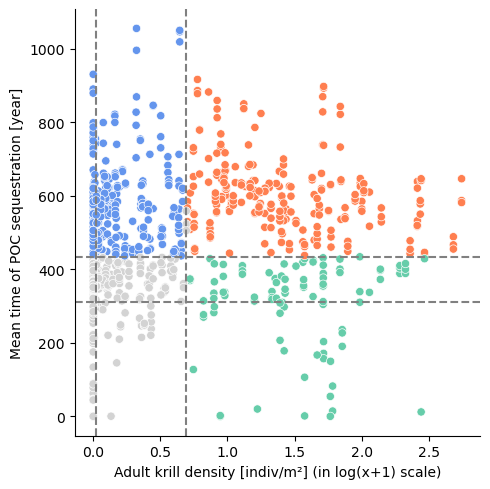

In [178]:
sns.relplot(x="STANDARDISED_KRILL_UNDER_1M2_log", y="mean_seq_time", 
            data=data_labeled,
            hue='label', 
            palette = ['lightgrey', 'cornflowerblue', 'mediumaquamarine', 'coral'],
            sizes = (10,70),
            legend=False)


plt.axvline(x=float(krill_quantile.iloc[0]), color='grey', linestyle='--')
plt.axvline(x=float(krill_quantile.iloc[1]), color='grey', linestyle='--')

plt.axhline(y=float(seq_quantile.iloc[0]), color='grey', linestyle='--')
plt.axhline(y=float(seq_quantile.iloc[1]), color='grey', linestyle='--')

plt.xlabel('Adult krill density [indiv/m²] (in log(x+1) scale)')
plt.ylabel('Mean time of POC sequestration [year]')

#plt.text(3.8, 400, '--- :  1/3 quantiles')

# saving in 'figure' folder
#os.chdir('./Key_Areas_krill_carbon_sequestration/figures/')
#plt.savefig('bi_plot_categories.png')

plt.show()


##### Map the KAKS (add coords)

In [179]:
# set index here with all coordinates
# make dataset with coordinates
coords = pd.DataFrame({'latitude':np.repeat(np.arange(-75, -45, 2), 180), # -75 to -51
                       'longitude': np.tile(np.arange(-179, 180, 2), 15), # -179 to 179
                       'label_grid': np.zeros(2700)}).set_index(['latitude', 'longitude'])

coords = coords.sort_values(['latitude', 'longitude'])

zones_data_complete = coords.join(data_labeled, how='left')
zones_data_complete#.dropna().shape # 2700  rows, 603 non-nan rows

label_grid  mean_seq_time  \
latitude longitude                              
-75      -179              0.0            NaN   
         -177              0.0            NaN   
         -175              0.0            NaN   
         -173              0.0            NaN   
         -171              0.0            NaN   
...                        ...            ...   
-47       171              0.0            NaN   
          173              0.0            NaN   
          175              0.0            NaN   
          177              0.0            NaN   
          179              0.0            NaN   

                    STANDARDISED_KRILL_UNDER_1M2_log  krill_catch_density_log  \
latitude longitude                                                              
-75      -179                                    NaN                      NaN   
         -177                                    NaN                      NaN   
         -175                                    NaN                      NaN   
         -173                                    NaN                      NaN   
         -171                                    NaN                      NaN   
...                                              ...                      ...   
-47       171                                    NaN                      NaN   
          173                                    NaN                      NaN   
          175                                    NaN                      NaN   
          177                                    NaN                      NaN   
          179                                    NaN                      NaN   

                    label  
latitude longitude         
-75      -179         NaN  
         -177         NaN  
         -175         NaN  
         -173         NaN  
         -171         NaN  
...                   ...  
-47       171         NaN  
          173         NaN  
          175         NaN  
          177         NaN  
          179         NaN  

[2700 rows x 5 columns]

In [180]:
zones_array = xr.Dataset.from_dataframe(zones_data_complete.drop(['krill_catch_density_log', 'STANDARDISED_KRILL_UNDER_1M2_log', 'mean_seq_time', 'label_grid'], axis = 1)) # convert into xarrayDataset
zones_array = xr.Dataset.to_array(zones_array)

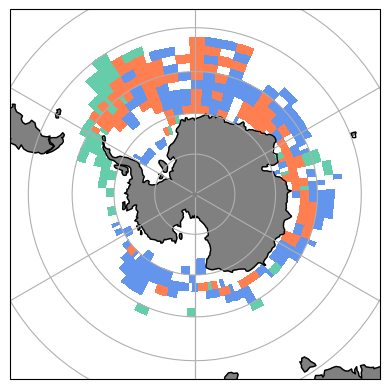

In [181]:
map_proj = ccrs.SouthPolarStereo()

p = zones_array.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj}, # the plot's projection
    levels=[1, 2, 3, 4], 
    colors = ['white', 'cornflowerblue', 'mediumaquamarine', 'coral']
)  


### Add features:
p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
plt.title('')

# save
#os.chdir('./Key_Areas_krill_carbon_sequestration/figures/')
#plt.savefig('p_overlap_krill_carbon.png')

plt.show(p)

# Compare to the zones identified with Krillpodym

## Compare KAKS

In [182]:
os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/output_results/')
zones_V1 = pd.read_csv('zones_krill_carbon.csv')
KAKS_V1 = zones_V1[zones_V1['label'] == 3] # select the KAKS

zones_V2 = zones_data_complete.reset_index()
KAKS_V2 = zones_V2[zones_V2['label'] == 3] # select the KAKS

In [183]:
display(KAKS_V2, KAKS_V1)

,latitude,longitude,label_grid,mean_seq_time,STANDARDISED_KRILL_UNDER_1M2_log,krill_catch_density_log,label
257,-73,-25,0.0,496.957662,1.408227,0.0,3.0
258,-73,-23,0.0,551.676224,1.408227,0.0,3.0
440,-71,-19,0.0,529.872044,0.702452,0.0,3.0
441,-71,-17,0.0,584.669142,0.702452,0.0,3.0
442,-71,-15,0.0,567.094330,0.702452,0.0,3.0
...,...,...,...,...,...,...,...
2070,-53,1,0.0,462.050139,1.574560,0.0,3.0
2071,-53,3,0.0,467.553699,1.574560,0.0,3.0
2078,-53,17,0.0,497.130997,0.871841,0.0,3.0
2079,-53,19,0.0,485.679216,0.871841,0.0,3.0


,latitude,longitude,label_grid,mean_seq_time,krill_adult_log,krill_catch_density_log,label
1,-75,-177,0.0,601.882341,1.70806,0.0,3.0
4,-75,-171,0.0,620.753036,1.66276,0.0,3.0
10,-75,-159,0.0,440.483941,2.13612,0.0,3.0
11,-75,-157,0.0,438.353419,1.58161,0.0,3.0
16,-75,-147,0.0,446.233208,1.82552,0.0,3.0
...,...,...,...,...,...,...,...
2078,-53,17,0.0,497.130997,1.82719,0.0,3.0
2079,-53,19,0.0,485.679216,1.64268,0.0,3.0
2081,-53,23,0.0,485.683388,1.67647,0.0,3.0
2082,-53,25,0.0,495.889159,1.93133,0.0,3.0


In [184]:
KAKS_comp = pd.merge(KAKS_V1.dropna(), KAKS_V2.dropna(), on = ['latitude',	'longitude'], how='outer', indicator = True)
KAKS_comp.set_index(['latitude',	'longitude'], inplace = True)
KAKS_comp.rename(columns={'_merge': 'comparison'}, inplace=True)
KAKS_comp['comparison'] = KAKS_comp['comparison'].replace({
    'left_only': 1,   
    'right_only': 2, 
    'both': 3})

KAKS_comp

label_grid_x  mean_seq_time_x  krill_adult_log  \
latitude longitude                                                   
-75      -177                0.0       601.882341          1.70806   
         -171                0.0       620.753036          1.66276   
         -159                0.0       440.483941          2.13612   
         -157                0.0       438.353419          1.58161   
         -147                0.0       446.233208          1.82552   
...                          ...              ...              ...   
-57       21                 NaN              NaN              NaN   
-55      -31                 NaN              NaN              NaN   
          9                  NaN              NaN              NaN   
-53       3                  NaN              NaN              NaN   
          21                 NaN              NaN              NaN   

                    krill_catch_density_log_x  label_x  label_grid_y  \
latitude longitude                                                     
-75      -177                             0.0      3.0           NaN   
         -171                             0.0      3.0           NaN   
         -159                             0.0      3.0           NaN   
         -157                             0.0      3.0           NaN   
         -147                             0.0      3.0           NaN   
...                                       ...      ...           ...   
-57       21                              NaN      NaN           0.0   
-55      -31                              NaN      NaN           0.0   
          9                               NaN      NaN           0.0   
-53       3                               NaN      NaN           0.0   
          21                              NaN      NaN           0.0   

                    mean_seq_time_y  STANDARDISED_KRILL_UNDER_1M2_log  \
latitude longitude                                                      
-75      -177                   NaN                               NaN   
         -171                   NaN                               NaN   
         -159                   NaN                               NaN   
         -157                   NaN                               NaN   
         -147                   NaN                               NaN   
...                             ...                               ...   
-57       21             614.020622                          2.015747   
-55      -31             476.417222                          1.896603   
          9              600.485983                          1.043102   
-53       3              467.553699                          1.574560   
          21             488.528118                          0.871841   

                    krill_catch_density_log_y  label_y comparison  
latitude longitude                                                 
-75      -177                             NaN      NaN          1  
         -171                             NaN      NaN          1  
         -159                             NaN      NaN          1  
         -157                             NaN      NaN          1  
         -147                             NaN      NaN          1  
...                                       ...      ...        ...  
-57       21                              0.0      3.0          2  
-55      -31                              0.0      3.0          2  
          9                               0.0      3.0          2  
-53       3                               0.0      3.0          2  
          21                              0.0      3.0          2  

[487 rows x 11 columns]

Text(0.5, 1.0, 'KAKS identified with KRILLPODYM (1), or KRILLBASE (2) or both (3))')

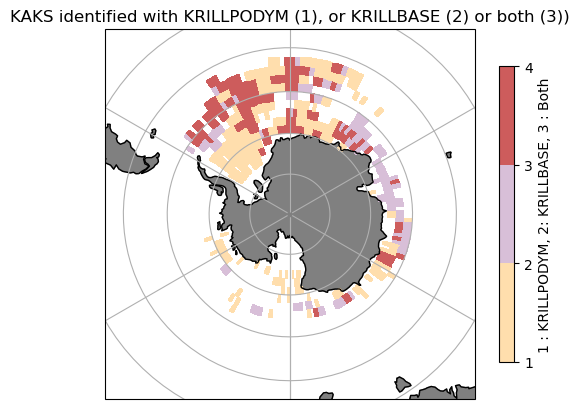

In [185]:
KAKS_comp = coords.join(KAKS_comp, how='left')
KAKS_comp_xarray = xr.Dataset.from_dataframe(KAKS_comp)

map_proj = ccrs.SouthPolarStereo()

p = KAKS_comp_xarray["comparison"].plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    levels=[1, 2, 3, 4], 
    colors = ['navajowhite', 'thistle', 'indianred']
) 

p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = "1 : KRILLPODYM, 2: KRILLBASE, 3 : Both" , shrink = 0.8)
plt.title('KAKS identified with KRILLPODYM (1), or KRILLBASE (2) or both (3))')

## Compare Blue zones (high carbon seq time)

In [186]:
Hseq_V1 = zones_V1[zones_V1['label'] == 1] # select the blue zones
Hseq_V2 = zones_V2[zones_V2['label'] == 1] # select the blue zones

Hseq_comp = pd.merge(Hseq_V1.dropna(), Hseq_V2.dropna(), on = ['latitude',	'longitude'], how='outer', indicator = True)
Hseq_comp.set_index(['latitude',	'longitude'], inplace = True)
Hseq_comp.rename(columns={'_merge': 'comparison'}, inplace=True)
Hseq_comp['comparison'] = Hseq_comp['comparison'].replace({
    'left_only': 1,   
    'right_only': 2, 
    'both': 3})

Text(0.5, 1.0, 'Hseq zones identified with KRILLPODYM (1), or KRILLBASE (2) or both (3))')

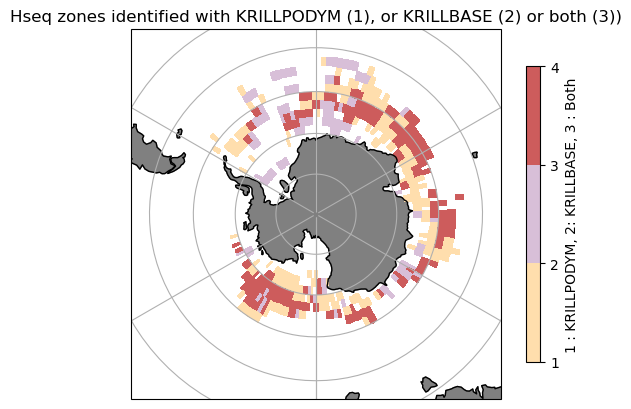

In [187]:
Hseq_comp = coords.join(Hseq_comp, how='left')
Hseq_comp_xarray = xr.Dataset.from_dataframe(Hseq_comp)

map_proj = ccrs.SouthPolarStereo()

p = Hseq_comp_xarray["comparison"].plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    levels=[1, 2, 3, 4], 
    colors = ['navajowhite', 'thistle', 'indianred']
) 

p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = "1 : KRILLPODYM, 2: KRILLBASE, 3 : Both" , shrink = 0.8)
plt.title('Hseq zones identified with KRILLPODYM (1), or KRILLBASE (2) or both (3))')

## Compare green zones (high krill density)

In [188]:
Hkrill_V1 = zones_V1[zones_V1['label'] == 2] # select the blue zones
Hkrill_V2 = zones_V2[zones_V2['label'] == 2] # select the blue zones

Hkrill_comp = pd.merge(Hkrill_V1.dropna(), Hkrill_V2.dropna(), on = ['latitude',	'longitude'], how='outer', indicator = True)
Hkrill_comp.set_index(['latitude',	'longitude'], inplace = True)
Hkrill_comp.rename(columns={'_merge': 'comparison'}, inplace=True)
Hkrill_comp['comparison'] = Hkrill_comp['comparison'].replace({
    'left_only': 1,   
    'right_only': 2, 
    'both': 3})

Text(0.5, 1.0, 'Hkrill zones identified with KRILLPODYM (1), or KRILLBASE (2) or both (3))')

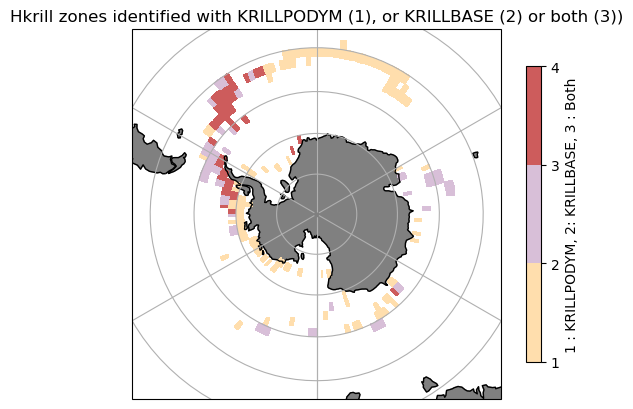

In [189]:
Hkrill_comp = coords.join(Hkrill_comp, how='left')
Hkrill_comp_xarray = xr.Dataset.from_dataframe(Hkrill_comp)

map_proj = ccrs.SouthPolarStereo()

p = Hkrill_comp_xarray["comparison"].plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    levels=[1, 2, 3, 4], 
    colors = ['navajowhite', 'thistle', 'indianred']
) 

p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = "1 : KRILLPODYM, 2: KRILLBASE, 3 : Both" , shrink = 0.8)
plt.title('Hkrill zones identified with KRILLPODYM (1), or KRILLBASE (2) or both (3))')

## Differences in areas identified as KAKS or other categories

In [190]:
# load the formated file of ocim
os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/outputs_formated_data')
OCIM = xr.open_dataset('fseq_OCIM2_48L_interpolated_SO.nc')

area_df = OCIM[['AREA', 'MASK']].isel(depth=0).to_dataframe().drop(['depth'], axis = 1).reset_index()
area_df = area_df[area_df['latitude'] <=-45].set_index(['latitude', 'longitude'])
area_df['True_area'] = area_df['AREA']*area_df['MASK']
area_df # 3240 rows

AREA      MASK     True_area
latitude longitude                                      
-79      -179.0     9.332850e+09  0.061111  5.703408e+08
         -177.0     9.332850e+09  0.061111  5.703408e+08
         -175.0     9.332850e+09  0.061111  5.703408e+08
         -173.0     9.332850e+09  0.061111  5.703408e+08
         -171.0     9.332850e+09  0.061111  5.703408e+08
...                          ...       ...           ...
-45       171.0     3.458337e+10  0.750000  2.593752e+10
          173.0     3.458337e+10  1.000000  3.458337e+10
          175.0     3.458337e+10  1.000000  3.458337e+10
          177.0     3.458337e+10  1.000000  3.458337e+10
          179.0     3.458337e+10  1.000000  3.458337e+10

[3240 rows x 3 columns]

In [191]:
KAKS_comp = KAKS_comp.join(other = area_df[['True_area']], how = 'left')
Hseq_comp = Hseq_comp.join(other = area_df[['True_area']], how = 'left')
Hkrill_comp = Hkrill_comp.join(other = area_df[['True_area']], how = 'left')

In [192]:
KAKS_comp_bygroup = KAKS_comp[['comparison', 'True_area']].groupby(['comparison']).sum()
Hseq_comp_bygroup = Hseq_comp[['comparison', 'True_area']].groupby(['comparison']).sum()
Hkrill_comp_bygroup = Hkrill_comp[['comparison', 'True_area']].groupby(['comparison']).sum()

C:\Users\anael\AppData\Local\Temp\ipykernel_29776\4135467132.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  KAKS_comp_bygroup = KAKS_comp[['comparison', 'True_area']].groupby(['comparison']).sum()
C:\Users\anael\AppData\Local\Temp\ipykernel_29776\4135467132.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Hseq_comp_bygroup = Hseq_comp[['comparison', 'True_area']].groupby(['comparison']).sum()
C:\Users\anael\AppData\Local\Temp\ipykernel_29776\4135467132.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

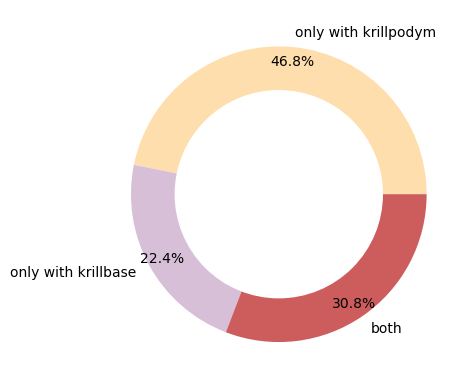

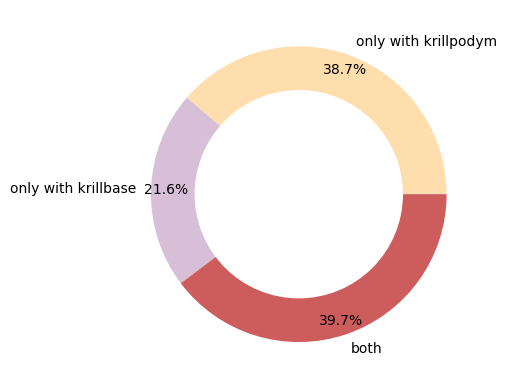

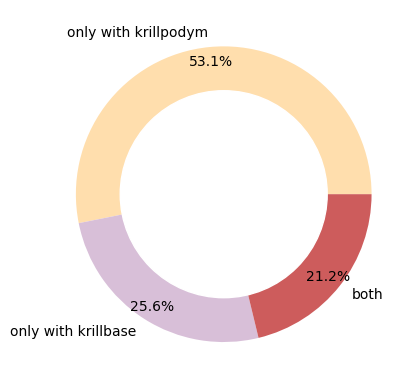

In [193]:
# plot % for KAKS
names = ['only with krillpodym', 'only with krillbase', 'both']
plt.pie(KAKS_comp_bygroup['True_area'], labels=names, colors=['navajowhite', 'thistle', 'indianred'], autopct='%1.1f%%', pctdistance=0.9,)

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.show()

# plot % for Blue zones
names = ['only with krillpodym', 'only with krillbase', 'both']
plt.pie(Hseq_comp_bygroup['True_area'], labels=names, colors=['navajowhite', 'thistle', 'indianred'], autopct='%1.1f%%', pctdistance=0.9,)

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.show()

# plot % for green zones
names = ['only with krillpodym', 'only with krillbase', 'both']
plt.pie(Hkrill_comp_bygroup['True_area'], labels=names, colors=['navajowhite', 'thistle', 'indianred'], autopct='%1.1f%%', pctdistance=0.9,)

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.show()

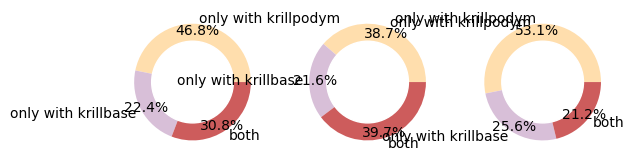

In [194]:
# Figure
#plt.subplots(nrows=3, ncols=3)

plt.subplot(1, 3, 1)
# plot % for KAKS
names = ['only with krillpodym', 'only with krillbase', 'both']
plt.pie(KAKS_comp_bygroup['True_area'], labels=names, colors=['navajowhite', 'thistle', 'indianred'], autopct='%1.1f%%', pctdistance=0.9,)

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)


plt.subplot(1, 3, 2)
# plot % for Blue zones
names = ['only with krillpodym', 'only with krillbase', 'both']
plt.pie(Hseq_comp_bygroup['True_area'], labels=names, colors=['navajowhite', 'thistle', 'indianred'], autopct='%1.1f%%', pctdistance=0.9,)

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)


plt.subplot(1, 3, 3)
# plot % for green zones
names = ['only with krillpodym', 'only with krillbase', 'both']
plt.pie(Hkrill_comp_bygroup['True_area'], labels=names, colors=['navajowhite', 'thistle', 'indianred'], autopct='%1.1f%%', pctdistance=0.9,)

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.show()

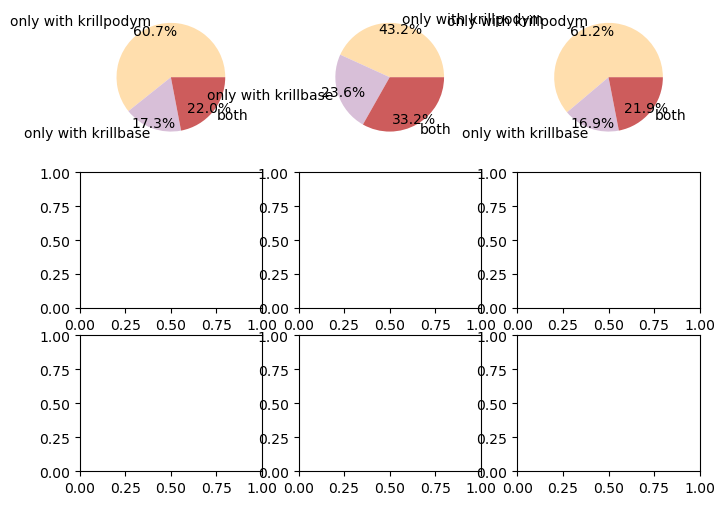

In [166]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8, 6))
 
# Dessiner des graphiques sur les axes individuels
names = ['only with krillpodym', 'only with krillbase', 'both']
axs[0, 0].pie(KAKS_comp_bygroup['True_area'], labels=names, colors=['navajowhite', 'thistle', 'indianred'], autopct='%1.1f%%', pctdistance=0.9,)

axs[0, 1].pie(Hseq_comp_bygroup['True_area'], labels=names, colors=['navajowhite', 'thistle', 'indianred'], autopct='%1.1f%%', pctdistance=0.9,)

axs[0, 2].pie(Hkrill_comp_bygroup['True_area'], labels=names, colors=['navajowhite', 'thistle', 'indianred'], autopct='%1.1f%%', pctdistance=0.9,)

plt.show()